### Daily Challenge: W6_D3

### Build a Retrieval Augmented Generation (RAG) System

* **RAG Daily Challenge – Goal**

Build a functional Retrieval Augmented Generation (RAG) system that can answer questions based on a dataset loaded from Hugging Face Datasets. The system should:

- Load the databricks/databricks-dolly-15k dataset
- Index the dataset content into a vector store
- Use a pre-trained model from Hugging Face
- Answer user queries by retrieving relevant documents and generating answers from them

---

* **Mandatory Prerequisites**

- Read the article: *Faiss | LangChain*
- Watch the videos:
  - *PyTorch in 100 Seconds*
  - *LangChain Explained in 13 Minutes*

---

* **Task Overview**

Our task is to implement a full RAG system using LangChain and Hugging Face libraries.

---

* **Step 1 – Set up your environment**

Ensure your Python environment includes:
- LangChain
- Transformers
- Torch
- Sentence-Transformers
- Hugging Face Datasets
- FAISS (CPU version)
- Langchain Community extensions

These tools cover dataset loading, text embedding, vector indexing, and LLM orchestration.

---

* **Step 2 – Load the Dataset**

Use the HuggingFaceDatasetLoader to load the dataset databricks/databricks-dolly-15k, specifying "context" as the field containing the content to be processed into documents.

---

* **Step 3 – Split Documents**

Split long documents into smaller chunks to fit LLM context limits. Use RecursiveCharacterTextSplitter with a chunk size of 1000 characters and an overlap of 150 characters.

---

* **Step 4 – Generate Embeddings**

Use a sentence-transformer model (e.g., all-MiniLM-L6-v2) to convert document chunks into dense semantic embeddings.

This enables similarity-based retrieval in the next step.

---

* **Step 5 – Create the Vector Store**

Use FAISS to create a vector index from the embeddings. This allows fast document retrieval based on similarity to a query.

---

* **Step 6 – Load a Language Model**

Load a pre-trained LLM from Hugging Face. Wrap it in a LangChain-compatible pipeline.

Initially, a QA model like Intel/dynamic_tinybert may be used, but it may require a switch to a generative model (like flan-t5-base) for full compatibility.

---

* **Step 7 – Build the Retrieval QA Chain**

Create a retriever from your FAISS index, and connect it with the LLM using RetrievalQA.  
The chain type "refine" or "stuff" can be used depending on the desired behavior.

---

* **Step 8 – Test Your System** 

Pose a natural-language question (e.g. "What is cheesemaking?") and check if the system retrieves relevant documents and generates a meaningful answer.

### 1. Setup your environment

In [ ]:
!pip install -q langchain
!pip install -q torch
!pip install -q transformers
!pip install -q sentence-transformers
!pip install -q datasets
!pip install -q faiss-cpu
!pip install -U langchain-community

### 2. Verify installations and imports

In [28]:
from langchain import HuggingFacePipeline
import torch
import transformers
import sentence_transformers
import datasets
import faiss
import umap
import matplotlib.pyplot as plt
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from langchain_community.document_loaders import HuggingFaceDatasetLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

In [3]:
# Print versions to ensure successful imports
print("torch version:", torch.__version__)
print("transformers version:", transformers.__version__)
print("sentence-transformers version:", sentence_transformers.__version__)
print("datasets version:", datasets.__version__)

torch version: 2.7.1+cpu
transformers version: 4.53.2
sentence-transformers version: 5.0.0
datasets version: 4.0.0


### Step 2 – Load the dataset from Hugging Face

In [4]:
# Define the dataset name and the column that contains the main text
dataset_name = "databricks/databricks-dolly-15k"
page_content_column = "context"

# Create a loader for the dataset
loader = HuggingFaceDatasetLoader(dataset_name, page_content_column)

# Load the dataset as LangChain documents
data = loader.load()

# Optional: print the first two documents to check
print(data[:2])

[Document(metadata={'instruction': 'When did Virgin Australia start operating?', 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.', 'category': 'closed_qa'}, page_content='"Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia\'s domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."'), Document(metadata={'instruction': 'Which is a species of fish? Tope or Rope', 'response': 'Tope', 'category': 'classification'}, page_content='""')]


### Step 3 – Split documents into chunks for processing

In [5]:
# Create a text splitter with chunk size of 1000 characters and 150 character overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,      # Maximum size of each chunk
    chunk_overlap=150     # Overlap between chunks to preserve context
)

# Apply the splitter to the loaded documents
docs = text_splitter.split_documents(data)

# Optional: print the first resulting document chunk
print(docs[0])

page_content='"Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."' metadata={'instruction': 'When did Virgin Australia start operating?', 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.', 'category': 'closed_qa'}


### Step 4 - Generate text embeddings for your documents

In [ ]:
# Define the model to be used for generating embeddings
modelPath = "sentence-transformers/all-MiniLM-L6-v2"
model_kwargs = {'device': 'cpu'}  # Run on CPU
encode_kwargs = {'normalize_embeddings': False}  # No normalization applied

# Create the embeddings object
embeddings = HuggingFaceEmbeddings(
    model_name=modelPath,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# (Optional) Test embedding generation with a simple string
text = "This is a test document."
query_result = embeddings.embed_query(text)
print(query_result[:5])  # Print the first 5 values of the embedding vector

### Step 5 - Build FAISS vector store from documents

In [ ]:
# Create a FAISS index from your document chunks and their embeddings
db = FAISS.from_documents(docs, embeddings)

# The FAISS index is now ready to be used for retrieval

### Step 6 – Load and wrap a Hugging Face QA model

In [ ]:
# Define the model name
model_name = "google/flan-t5-base"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Create a generation pipeline
generator_pipeline = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    do_sample=False  # deterministic output
)

# Wrap the pipeline for LangChain
llm = HuggingFacePipeline(pipeline=generator_pipeline)

tokenizer_config.json: 0.00B [00:00, ?B/s]

c:\Users\julia\Downloads\GenAI\GitHub\nlp_course_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\julia\.cache\huggingface\hub\models--google--flan-t5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cpu


### Step 7 - Create a Retrieval QA Chain

In [21]:
# Create a retriever from the FAISS index
retriever = db.as_retriever(search_kwargs={"k": 2})  # You can change 'k' for more or fewer documents

# Create the QA chain by connecting retriever and LLM
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="refine",  # or "stuff", "map_reduce", etc.
    retriever=retriever,
    return_source_documents=False
)

### Step 8 - Run a test query

In [23]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",  # "stuff" is faster and less verbose
    retriever=retriever,
    return_source_documents=False
)

In [24]:
# Define a test question
question = "What is cheesemaking?"

# Run the QA chain on the question
result = qa.run({"query": question})

# Print the answer generated by the model
print(result)

control the spoiling of milk into cheese


In [25]:
question = "When did Virgin Australia start operating?"
result = qa.run({"query": question})
print(result)

31 August 2000


### 2D UMAP projection of document embeddings

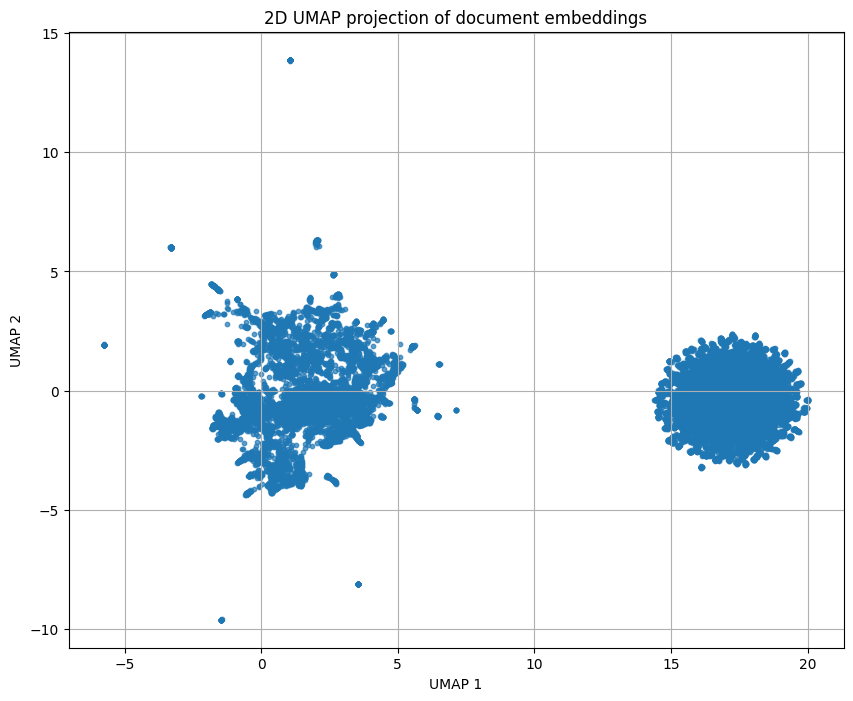

In [29]:
# Step 1: Get all embeddings from the FAISS index
vectors = db.index.reconstruct_n(0, db.index.ntotal)

# Step 2: Import UMAP for dimensionality reduction
import umap
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embedding_2d = reducer.fit_transform(vectors)

# Step 3: Plot the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, alpha=0.7)
plt.title("2D UMAP projection of document embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

### RAG System Summary – Markdown Report

### 1. Goal

The objective was to build a full Retrieval Augmented Generation (RAG) system using:
- Hugging Face Datasets and Transformers
- Sentence Transformers for embedding
- FAISS for vector-based retrieval
- LangChain to orchestrate the pipeline

---

### 2. Pipeline Steps

- **Dataset Loading**  
  Loaded the databricks/databricks-dolly-15k dataset with HuggingFaceDatasetLoader, using the context field as source text.

- **Text Splitting**  
  Applied RecursiveCharacterTextSplitter with 1000 character chunks and 150 overlap.

- **Embeddings Generation**  
  Used sentence-transformers/all-MiniLM-L6-v2 to convert text into dense semantic vectors.

- **Vector Indexing**  
  Built a FAISS vector store to enable fast similarity search based on these embeddings.

- **LLM Integration**  
  Initially tried a question-answering model (Intel/dynamic_tinybert) which failed due to format mismatch.  
  Replaced with google/flan-t5-base, a generative model compatible with LangChain's text2text prompts.

- **RAG Chain Creation**  
  Created a RetrievalQA chain with the "stuff" chain type, linking FAISS retriever to the LLM.

---

### Conclusion

This project successfully demonstrates the construction of a modular and interpretable Retrieval Augmented Generation (RAG) pipeline using LangChain and Hugging Face tools.

The system can retrieve relevant document chunks based on a user query and generate coherent answers using a generative language model. Key insights and interpretations include:

- **RAG pipeline logic is working end-to-end**: from dataset loading to retrieval and generation, every component is well connected and functional.
  
- **Document splitting and embedding strategy matters**: the choice of chunk size and overlap (1000 / 150) preserved context while enabling precise retrieval.

- **Embedding model (all-MiniLM-L6-v2) provided useful semantic space**: similar documents are clustered together in embedding space, which facilitates efficient retrieval via FAISS.

- **Visualization using UMAP revealed clear document clusters**:
  - The dense cluster on the right likely corresponds to highly homogeneous entries (e.g. multiple-choice answers or repeated instructional templates).
  - The dispersed cluster on the left may contain more diverse or descriptive contexts (e.g. long-form explanations or open-ended Q&A).
  - This separation confirms that the embedding space captures meaningful semantic structure in the dataset.

- **Model choice affects RAG compatibility**:
  - Question-answering models expect structured input (context + question) and don’t integrate well with LangChain’s open-ended prompt strategy.
  - Switching to a text-to-text generative model like flan-t5-base solved compatibility issues and enabled smooth inference.

- **Retrieval QA chain with stuff chain type was effective and simple**:
  - It avoids context truncation and gives the LLM a complete view of selected documents, suitable for shorter inputs and direct question answering.

This foundational RAG system can now be extended for further use cases, including chatbot design, document search, or domain-specific assistants.